In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pokemon-images-and-types/pokemon.csv
/kaggle/input/pokemon-images-and-types/images/images/throh.png
/kaggle/input/pokemon-images-and-types/images/images/samurott.png
/kaggle/input/pokemon-images-and-types/images/images/venomoth.png
/kaggle/input/pokemon-images-and-types/images/images/latios.png
/kaggle/input/pokemon-images-and-types/images/images/shinx.png
/kaggle/input/pokemon-images-and-types/images/images/durant.png
/kaggle/input/pokemon-images-and-types/images/images/geodude.png
/kaggle/input/pokemon-images-and-types/images/images/wingull.png
/kaggle/input/pokemon-images-and-types/images/images/miltank.png
/kaggle/input/pokemon-images-and-types/images/images/castform.png
/kaggle/input/pokemon-images-and-types/images/images/squirtle.png
/kaggle/input/pokemon-images-and-types/images/images/shaymin-land.png
/kaggle/input/pokemon-images-and-types/images/images/raikou.png
/kaggle/input/pokemon-images-and-types/images/images/mawile.png
/kaggle/input/pokemon-images-and-types

1. GAN을 통한 이미지 생성 후, 학습 알고리즘에서 타입을 유추하게끔 한다.
2. 타입을 random으로 받아 만들고, 이를 GAN에서 이용해 이미지를 만든다.

GAN = Generator + Discriminator

- Generator: input -> repeat(Dense) -> reshape -> repeat(Convolutional -> Convolutional -> Max-Pooling, n) -> Convolutional -> output
- Discriminator: input -> repeat(Convolutional -> Convolutional -> Max-Pooling, n) -> Flatten -> repeat(Dense, n) -> output

### 0. 데이터 확인

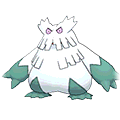

In [4]:
from PIL import Image

images = Image.open("../input/pokemon-images-and-types/images/images/abomasnow.png")
images

In [5]:
print(list(images.getdata()))

[(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0

```
count = 0
for dirname, _, filenames in os.walk('/kaggle/input/pokemon-images-and-types/images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
print(count)
```

In [ ]:
# labels = pd.read_csv("../input/pokemon-images-and-types/pokemon.csv", usecols=(1, 2))
# labels.describe()

### 2. 전처리

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#### 판별자 input: 전체 데이터 불러오기

In [7]:
images.mode

'RGBA'

grayscale의 image가 존재하는 것처럼 보였다. 이걸 방치하는 게 맞는 걸까.

In [14]:
data = []
for dirname, _, filenames in os.walk('/kaggle/input/pokemon-images-and-types/images'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        img = Image.open(path).convert("RGBA")
        data.append(np.asarray(img, dtype=np.int8))
print(len(data), data[0])

809 [[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


image 크기 확인

In [15]:
data[0].shape

(120, 120, 4)

In [18]:
count = 0
for idx in range(len(data)):
    if data[idx].shape != data[0].shape:
        count += 1
        print(idx, len(data[idx]), sep="\t")
print(count)

0


난수로 data 확인

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

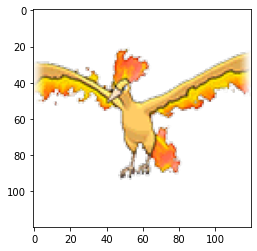

In [28]:
# 사랑합니다, matplotlib
random_idx = np.random.randint(0, len(data))
plt.imshow(Image.fromarray(data[random_idx], "RGBA"))

#### 생성자 input: tokenize를 위한 형태 만들기

In [ ]:
# labels.info()

In [ ]:
# classes = []
# for index in range(labels.shape[0]):
#     part = []
#     part.append(labels.iloc[index, 0])
#     if labels.iloc[index, 1] is not np.nan:
#         part.append(labels.iloc[index, 1])
#     classes.append(part)
# classes[0:5]

tokenize

In [ ]:
# types = pd.Series(labels.iloc[:, 0]).append(labels.iloc[:, 1]).unique()
# types[18] = ""

In [ ]:
# ltoken = Tokenizer()
# ltoken.fit_on_texts(types)
# ltoken.document_count

In [ ]:
# classes = ltoken.texts_to_sequences(classes)
# classes = pad_sequences(classes)
# classes[0:5]

### 3. 모델 구성

In [29]:
from keras.models import Model, Input, Sequential
from keras.layers import BatchNormalization, Dropout
from keras.layers import Reshape, Embedding, Conv2D, UpSampling2D, MaxPool2D, Flatten, Dense, LeakyReLU

import tensorflow as tf

### generator: type을 넣으면 image가 생성

In [80]:
generator = Sequential()
generator.add(Dense(30 * 30 * 256, activation=LeakyReLU(0.2), input_dim=100))
generator.add(Reshape((30, 30, 256)))
generator.add(Conv2D(256, kernel_size=5, padding="same"))
generator.add(Conv2D(128, kernel_size=7, padding="same", activation=LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(BatchNormalization())
generator.add(Conv2D(128, kernel_size=5, padding="same"))
generator.add(Conv2D(64, kernel_size=7, padding="same", activation=LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(BatchNormalization())
generator.add(Conv2D(4, kernel_size=5, padding="same", activation="tanh"))
generator.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 230400)            23270400  
_________________________________________________________________
reshape_8 (Reshape)          (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 30, 30, 256)       1638656   
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 30, 30, 128)       1605760   
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 60, 60, 128)       0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 60, 60, 128)       512       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 60, 60, 128)     

### discriminator: image의 진위 여부 판별

In [81]:
discriminator = Sequential()
discriminator.add(Conv2D(256, kernel_size=5, padding="same", input_shape=(120, 120, 4)))
discriminator.add(Conv2D(128, kernel_size=7, padding="same", activation=LeakyReLU(0.2)))
discriminator.add(MaxPool2D(pool_size=2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, padding="same"))
discriminator.add(Conv2D(64, kernel_size=7, padding="same", activation=LeakyReLU(0.2)))
discriminator.add(MaxPool2D(pool_size=2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(64, kernel_size=5, padding="same"))
discriminator.add(Conv2D(32, kernel_size=7, padding="same", activation=LeakyReLU(0.2)))
discriminator.add(MaxPool2D(pool_size=2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 120, 120, 256)     25856     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 120, 120, 128)     1605760   
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 60, 60, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 60, 60, 128)       409728    
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 60, 60, 64)        401472    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 64)      

In [82]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

label이 전체 이미지에 미치는 영향을 생각하면 -> label + random

In [ ]:
# ginput = Input(shape=(2, ))

In [ ]:
# grandom = np.random.normal(0, 1, (5, 200))
# gtype = Embedding(ltoken.document_count, 5)(ginput)
# gmiddle = tf.matmul(gtype, grandom)
# gpoint = Flatten()(gmiddle)
# prepare = Model(ginput, gpoint)
# prepare.summary()

In [ ]:
# goutput = discriminator(generator(prepare(ginput)))

In [83]:
ginput = Input(shape=(100, ))
goutput = discriminator(generator(ginput))
gan = Model(ginput, goutput)
gan.compile(loss="binary_crossentropy", optimizer="adam")

### train 함수 짜기

In [85]:
X_train = np.array(data).astype("float32")
X_train = (X_train - 127.5) / 127.5
X_train[0]

array([[[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       ...,

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        ...,
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[-1.

In [86]:
X_train.shape

(809, 120, 120, 4)

In [84]:
if not os.path.exists("./gan_pokemon"):
    os.makedirs("./gan_pokemon")

In [87]:
def gan_train(epoch, batch_size, saving_interval):
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

#         noise = np.random.randint(0, ltoken.document_count, (batch_size, 2))
#         gen_imgs = generator.predict(prepare.predict(noise))
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss = np.add(d_loss_real, d_loss_fake) * 0.5
        g_loss = gan.train_on_batch(noise, true)

        print(f"epoch: {i}", "d_loss: %.4f" % d_loss, "g_loss: %.4f" % g_loss)
        
        if i % saving_interval == 0:
#             noise = np.random.randint(0, ltoken.document_count, (25, 2))
#             gen_imgs = generator.predict(prepare.predict(noise))
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            # generator's output = [-1, 1]
            gen_imgs = 127.5 * gen_imgs + 127.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    img = np.array(gen_imgs[count, :, :, :], dtype=np.int8)
                    axs[j, k].imshow(Image.fromarray(img, "RGBA"))
                    axs[j, k].axis("off")
                    count += 1
            fig.savefig("./gan_pokemon/gan_pokemon_%d.png" % i)

In [78]:
np.random.seed(3)
tf.random.set_seed(3)

In [ ]:
gan_train(4001, 30, 200) # 4001

epoch: 0 d_loss: 0.9260 g_loss: 0.0450
epoch: 1 d_loss: 182.2457 g_loss: 0.0004
epoch: 2 d_loss: 3.2152 g_loss: 227.7810
epoch: 3 d_loss: 293.9039 g_loss: 17.1035
epoch: 4 d_loss: 13.0446 g_loss: 12.9970
epoch: 5 d_loss: 116.5696 g_loss: 29.0676
epoch: 6 d_loss: 3.7525 g_loss: 63.3190
epoch: 7 d_loss: 93.1735 g_loss: 71.3276
epoch: 8 d_loss: 58.2876 g_loss: 179.9765
epoch: 9 d_loss: 436.2898 g_loss: 86.7378
epoch: 10 d_loss: 10.1680 g_loss: 316.4529
epoch: 11 d_loss: 141.4180 g_loss: 143.5668
epoch: 12 d_loss: 192.8112 g_loss: 81.0200
epoch: 13 d_loss: 70.3616 g_loss: 151.4074
epoch: 14 d_loss: 84.4425 g_loss: 318.8955
epoch: 15 d_loss: 0.0881 g_loss: 674.7028
epoch: 16 d_loss: 0.0000 g_loss: 839.4513
epoch: 17 d_loss: 0.0000 g_loss: 841.1642
epoch: 18 d_loss: 5.1758 g_loss: 1253.4503
epoch: 19 d_loss: 0.0000 g_loss: 1113.6810
epoch: 20 d_loss: 0.0000 g_loss: 963.0588
epoch: 21 d_loss: 0.0000 g_loss: 527.4964
epoch: 22 d_loss: 0.0000 g_loss: 280.0138
epoch: 23 d_loss: 0.0000 g_loss: 44

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, UpSampling2D, Conv2D, Activation, Dropout, Flatten, Dense, Input

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os

if not os.path.exists("./gan_pokemon"):
    os.makedirs("./gan_pokemon")

np.random.seed(3)
tf.random.set_seed(3)


generator = Sequential()
generator.add(Dense(128 * 30 * 30, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((30, 30, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding="same"))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(4, kernel_size=5, padding="same", activation="tanh"))
# generator.summary()


discriminator = Sequential()
discriminator.add(Conv2D(64, input_shape=(120, 120, 4), kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))
# discriminator.summary()

discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False


ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))

gan = Model(ginput, dis_output)
gan.compile(loss="binary_crossentropy", optimizer="adam")


def gan_train(epoch, batch_size, saving_interval):
    X_train = np.array(data).astype("float32")
    X_train = (X_train - 127.5) / 127.5

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss = np.add(d_loss_real, d_loss_fake) * 0.5
        g_loss = gan.train_on_batch(noise, true)

        print(f"epoch: {i}", "d_loss: %.4f" % d_loss, "g_loss: %.4f" % g_loss)

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            # generator's output = [-1, 1]
#             gen_imgs = 0.5 * gen_imgs + 0.5
            gen_imgs = 127.5 * gen_imgs + 127.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
#                     axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap="gray")
                    img = np.array(gen_imgs[count, :, :, :], dtype=np.int8)
                    axs[j, k].imshow(Image.fromarray(img, "RGBA"))
                    axs[j, k].axis("off")
                    count += 1
            fig.savefig("./gan_pokemon/gan_pokemon_%d.png" % i)
            # 맞네, 한 번에 25개의 그림(0-24)을 저장하는 것.


gan_train(4001, 32, 200)

11493376/11490434 [==============================] - 0s 0us/step


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape (32, 28, 28, 1)
